# Classification: Good vs. Bad Road Conditions

Description: Classifying good and bad road conditions using accelerometer and gyroscope data <b>without</b> pothole labels.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

/Users/Shouvik/Applications/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Load and combine all trip data files

In [2]:
numGoodTrips = 10
numBadTrips = 5
dataDir = 'data/Good_Road_Bad_Road/'
goodRoadDF = pd.DataFrame()
badRoadDF = pd.DataFrame()

# Put all good road data into goodRoadDF
for goodRoadIndex in range(1, numGoodTrips+1):
    goodRoadFilePath = dataDir + 'good%s_intervals.csv' % goodRoadIndex
    tripDF = pd.read_csv(goodRoadFilePath)
    goodRoadDF = goodRoadDF.append(tripDF)
    
# Put all bad road data into badRoadDF
for badRoadIndex in range(1, numBadTrips+1):
    badRoadFilePath = dataDir + 'bad%s_intervals.csv' % badRoadIndex
    tripDF = pd.read_csv(badRoadFilePath)
    badRoadDF = badRoadDF.append(tripDF)

# Some data cleaning
goodRoadDF.drop('Unnamed: 0', axis=1, inplace=True)
badRoadDF.drop('Unnamed: 0', axis=1, inplace=True)
goodRoadDF.dropna(inplace=True)
badRoadDF.dropna(inplace=True)
goodRoadDF.reset_index(drop=True, inplace=True)
badRoadDF.reset_index(drop=True, inplace=True)

print (goodRoadDF.shape)
print (badRoadDF.shape)
badRoadDF.head()

(373, 27)
(86, 27)


,meanSpeed,sdSpeed,maxAccelX,maxAccelY,maxAccelZ,maxGyroX,maxGyroY,maxGyroZ,minAccelX,minAccelY,...,meanGyroX,meanGyroY,meanGyroZ,sdAccelX,sdAccelY,sdAccelZ,sdGyroX,sdGyroY,sdGyroZ,condition
0,2.786,1.254071,0.180893,-0.852554,0.570755,0.018191,0.055567,0.075220,-0.196838,-0.962219,...,-0.014586,-0.049366,0.011600,0.107026,0.031894,0.069673,0.026626,0.063336,0.039347,1.0
1,13.550,0.432178,0.080521,-0.834000,0.357269,0.005312,0.147995,0.196600,-0.125839,-1.069000,...,-0.043707,-0.054707,0.019952,0.062265,0.077701,0.045871,0.055614,0.133870,0.076479,1.0
2,13.500,0.316228,0.146255,-0.890030,0.209290,0.012635,0.037533,0.094294,-0.035217,-1.084564,...,-0.052779,-0.018908,0.009957,0.051928,0.062375,0.070751,0.070474,0.064439,0.043749,1.0
3,6.475,1.059363,0.020554,-0.971405,0.084045,0.022691,-0.028601,0.092236,-0.195404,-1.027863,...,-0.016482,-0.246347,0.057936,0.061621,0.016343,0.043332,0.020756,0.111809,0.030293,1.0
4,4.230,0.569210,0.654892,-0.796127,0.741577,0.250886,0.321798,0.318117,-0.332016,-1.308212,...,0.017377,-0.015430,0.005762,0.269076,0.162553,0.225503,0.145116,0.240460,0.170115,1.0


### Setup Features and Labels

In [3]:
a = goodRoadDF['condition']
b = badRoadDF['condition']
y = np.append(a,b)
frames = [goodRoadDF, badRoadDF]
X = pd.concat(frames)
X = X[['meanSpeed', 'sdSpeed', 'maxAccelX', 'maxAccelY', 'maxAccelZ', 'maxGyroX', 
       'maxGyroY', 'maxGyroZ', 'minAccelX', 'minAccelY', 'minAccelZ', 'minGyroX', 
       'minGyroY', 'minGyroZ', 'meanAccelX', 'meanAccelY', 'meanAccelZ', 
       'meanGyroX', 'meanGyroY', 'meanGyroZ', 'sdAccelX', 'sdAccelY', 'sdAccelZ', 
       'sdGyroX', 'sdGyroY', 'sdGyroZ']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### Imbalance of Classes

In [4]:
pd.value_counts(y)

0.0    373
1.0     86
dtype: int64

## Classification: Baseline Model

This is the same as predicting the majority class for every instance. Will serve as a baseline for accuracy/precision/recall.

In [5]:
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print "Accuracy:", accuracy
print "\nClassification Report:"
print(classification_report(y_test, y_pred))
print "\nConfusion matrix:"
confusion_matrix(y_test, y_pred)

Accuracy: 0.822368421053

Classification Report:
             precision    recall  f1-score   support

        0.0       0.82      1.00      0.90       125
        1.0       0.00      0.00      0.00        27

avg / total       0.68      0.82      0.74       152


Confusion matrix:


/Users/Shouvik/Applications/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[125,   0],
       [ 27,   0]])

## Classification: SVM

('Final SVM Test Accuracy: ', 0.93421052631578949)


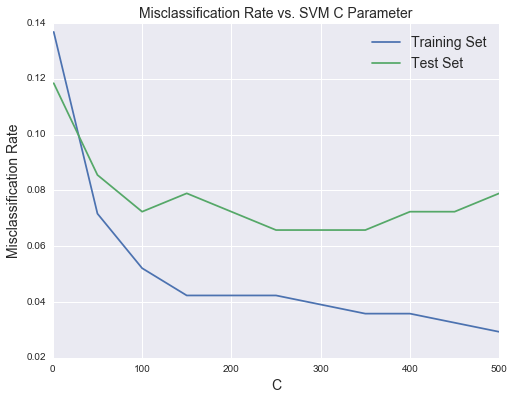

In [6]:
Cs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
cvAccuracy = []
trainMisclassRate = []
testMisclassRate = []

for c in Cs:
    clf = svm.SVC(C=c)
    scores = cross_val_score(clf, X,y, cv=5)
    cvAccuracy.append(np.mean(scores))
    clf.fit(X_train,y_train)
    y_fitted = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    trainMisclassRate.append(np.mean(y_fitted!=y_train))
    testMisclassRate.append(np.mean(y_pred!=y_test))

plt.figure(figsize=(8,6))
plt.plot(Cs, trainMisclassRate, label="Training Set")
plt.plot(Cs, testMisclassRate, label="Test Set")
plt.legend(loc='upper right', fontsize=14)
plt.title('Misclassification Rate vs. SVM C Parameter', fontsize=14)
plt.xlabel('C', fontsize=14)
plt.ylabel('Misclassification Rate', fontsize=14)

# Final SVM Classifier
clf = svm.SVC(C=250)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print ("Final SVM Test Accuracy: ", accuracy)

### Evaluation Metrics: SVM

In [52]:
e = [1,2,3]
b = [1,2,3]
confusion_matrix(y_test, y_pred)

array([[119,   6],
       [  4,  23]])

In [53]:
a = classification_report(y_test, y_pred)
print (a)

             precision    recall  f1-score   support

        0.0       0.97      0.95      0.96       125
        1.0       0.79      0.85      0.82        27

avg / total       0.94      0.93      0.94       152



## Classification: Logistic Regression

Final Logistic Test Accuracy:  0.927631578947


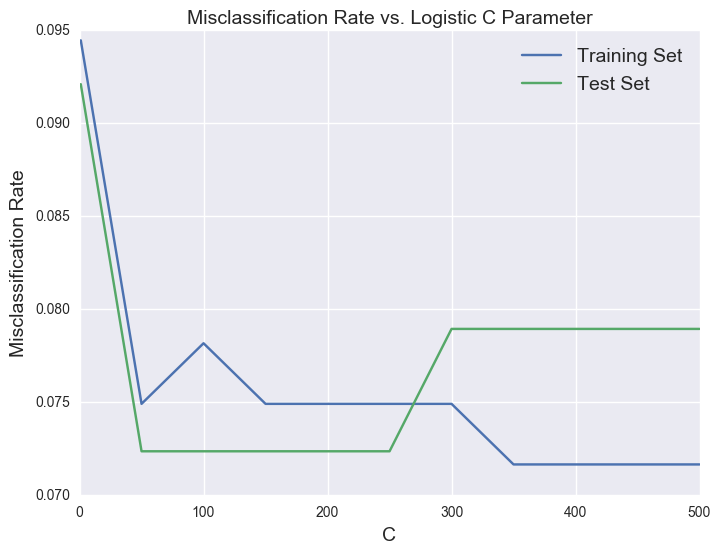

In [54]:
Cs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
cvAccuracy = []
trainMisclassRate = []
testMisclassRate = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

for c in Cs:
    clf = LogisticRegression(C=c)
    scores = cross_val_score(clf, X,y, cv=5)
    cvAccuracy.append(np.mean(scores))
    clf.fit(X_train,y_train)
    y_fitted = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    trainMisclassRate.append(np.mean(y_fitted!=y_train))
    testMisclassRate.append(np.mean(y_pred!=y_test))

plt.figure(figsize=(8,6))
plt.plot(Cs, trainMisclassRate, label="Training Set")
plt.plot(Cs, testMisclassRate, label="Test Set")
plt.legend(loc='upper right', fontsize=14)
plt.title('Misclassification Rate vs. Logistic C Parameter', fontsize=14)
plt.xlabel('C', fontsize=14)
plt.ylabel('Misclassification Rate', fontsize=14)

# Final Logistic Classifier
clf = LogisticRegression(C=250)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print ("Final Logistic Test Accuracy: ", accuracy)

### Evaluation Metrics: LR

In [55]:
e = [1,2,3]
b = [1,2,3]
confusion_matrix(y_test, y_pred)

array([[121,   4],
       [  7,  20]])

In [56]:
a = classification_report(y_test, y_pred)
print (a)

             precision    recall  f1-score   support

        0.0       0.95      0.97      0.96       125
        1.0       0.83      0.74      0.78        27

avg / total       0.93      0.93      0.93       152



## Classification: Random Forest

Final Random Forest Test Accuracy:  0.907894736842


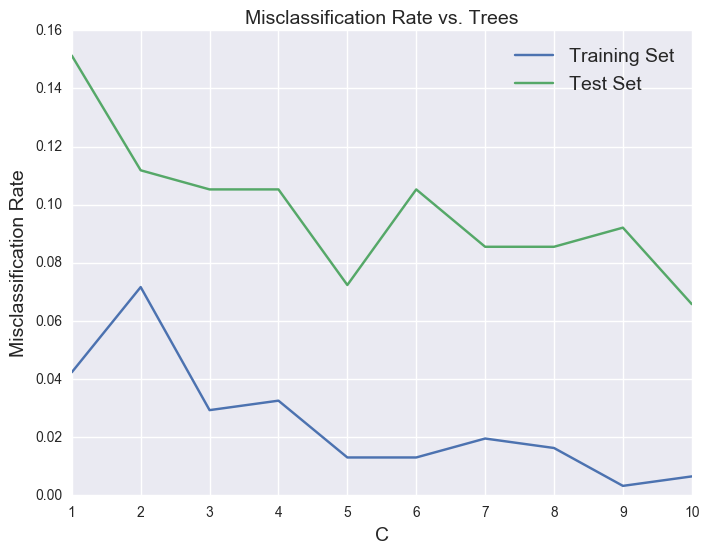

In [68]:
Cs = [1,2,3,4,5,6,7,8,9,10]
cvAccuracy = []
trainMisclassRate = []
testMisclassRate = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

for c in Cs:
    clf = RandomForestClassifier(n_estimators=c)
    scores = cross_val_score(clf, X,y, cv=5)
    cvAccuracy.append(np.mean(scores))
    clf.fit(X_train,y_train)
    y_fitted = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    trainMisclassRate.append(np.mean(y_fitted!=y_train))
    testMisclassRate.append(np.mean(y_pred!=y_test))

plt.figure(figsize=(8,6))
plt.plot(Cs, trainMisclassRate, label="Training Set")
plt.plot(Cs, testMisclassRate, label="Test Set")
plt.legend(loc='upper right', fontsize=14)
plt.title('Misclassification Rate vs. Trees', fontsize=14)
plt.xlabel('C', fontsize=14)
plt.ylabel('Misclassification Rate', fontsize=14)

# Final Random Forest Classifier
clf = RandomForestClassifier(n_estimators=6)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print ("Final Random Forest Test Accuracy: ", accuracy)

### Evaluation Metrics: Random Forest

In [69]:
e = [1,2,3]
b = [1,2,3]
confusion_matrix(y_test, y_pred)

array([[121,   4],
       [ 10,  17]])

In [70]:
a = classification_report(y_test, y_pred)
print (a)

             precision    recall  f1-score   support

        0.0       0.92      0.97      0.95       125
        1.0       0.81      0.63      0.71        27

avg / total       0.90      0.91      0.90       152



## Classification: Decision Tree

In [78]:
Cs = [1,2,3,4,5,6,7,8,9,10]
cvAccuracy = []
trainMisclassRate = []
testMisclassRate = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# for c in Cs:
#     clf = RandomForestClassifier(n_estimators=c)
#     scores = cross_val_score(clf, X,y, cv=5)
#     cvAccuracy.append(np.mean(scores))
#     clf.fit(X_train,y_train)
#     y_fitted = clf.predict(X_train)
#     y_pred = clf.predict(X_test)
#     trainMisclassRate.append(np.mean(y_fitted!=y_train))
#     testMisclassRate.append(np.mean(y_pred!=y_test))

# plt.figure(figsize=(8,6))
# plt.plot(Cs, trainMisclassRate, label="Training Set")
# plt.plot(Cs, testMisclassRate, label="Test Set")
# plt.legend(loc='upper right', fontsize=14)
# plt.title('Misclassification Rate vs. Trees', fontsize=14)
# plt.xlabel('C', fontsize=14)
# plt.ylabel('Misclassification Rate', fontsize=14)

# Final Decision Trees Classifier
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print ("Final Decision Tree Test Accuracy: ", accuracy)

Final Decision Tree Test Accuracy:  0.875


### Evaluation Metrics: Decisipon Trees

In [75]:
e = [1,2,3]
b = [1,2,3]
confusion_matrix(y_test, y_pred)

array([[114,  11],
       [  8,  19]])

In [76]:
a = classification_report(y_test, y_pred)
print (a)

             precision    recall  f1-score   support

        0.0       0.93      0.91      0.92       125
        1.0       0.63      0.70      0.67        27

avg / total       0.88      0.88      0.88       152



## Classification: Gradient Boosting

Final Gradient Boosting Test Accuracy:  0.934210526316


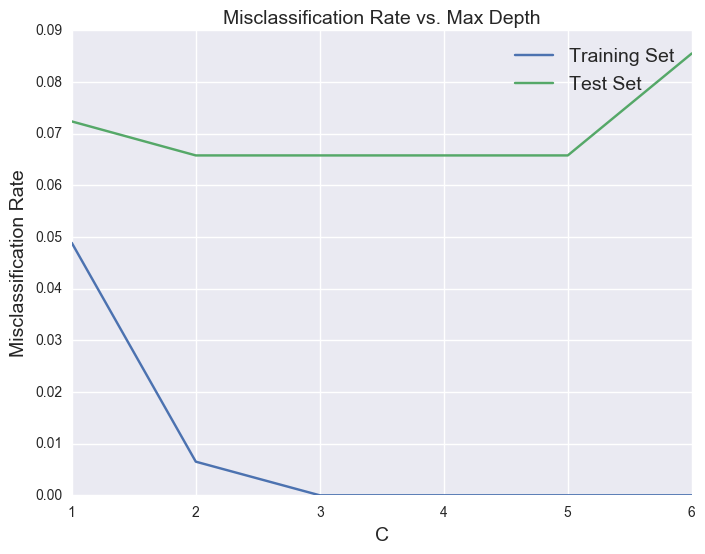

In [94]:
Cs = [1,2,3,4,5,6]
cvAccuracy = []
trainMisclassRate = []
testMisclassRate = []

for c in Cs:
    clf = GradientBoostingClassifier(max_depth=c)
    scores = cross_val_score(clf, X,y, cv=5)
    cvAccuracy.append(np.mean(scores))
    clf.fit(X_train,y_train)
    y_fitted = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    trainMisclassRate.append(np.mean(y_fitted!=y_train))
    testMisclassRate.append(np.mean(y_pred!=y_test))

plt.figure(figsize=(8,6))
plt.plot(Cs, trainMisclassRate, label="Training Set")
plt.plot(Cs, testMisclassRate, label="Test Set")
plt.legend(loc='upper right', fontsize=14)
plt.title('Misclassification Rate vs. Max Depth', fontsize=14)
plt.xlabel('C', fontsize=14)
plt.ylabel('Misclassification Rate', fontsize=14)

# Final Gradient Boosting Classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
clf = GradientBoostingClassifier(max_depth = 4)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred==y_test)
print ("Final Gradient Boosting Test Accuracy: ", accuracy)

In [95]:
e = [1,2,3]
b = [1,2,3]
confusion_matrix(y_test, y_pred)

array([[123,   2],
       [  8,  19]])

In [96]:
a = classification_report(y_test, y_pred)
print (a)

             precision    recall  f1-score   support

        0.0       0.94      0.98      0.96       125
        1.0       0.90      0.70      0.79        27

avg / total       0.93      0.93      0.93       152



## Final Model: SVM

Training the SVM model on the entire dataset (not just training data).

In [12]:
clf = svm.SVC(C=250)
clf.fit(X, y)
clf

SVC(C=250, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Save classifier to pickled file.

In [13]:
import cPickle as pickle

roadConditionsClassifier = {
    'classifier': clf
}
pickle.dump(roadConditionsClassifier, open('roadConditionsClassifier.p', 'wb'))